# Load Data Preprocessing

This notebook peformes the preprocessing of the load datasets

### Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

### Get CSV Data And Rename Columns

In [2]:
#Import csv file with second row as header
dff = pd.read_csv('../../raw_data/2012-2013 Solar home electricity data.csv', header=1)

#Change Date Format
dff.date = pd.to_datetime(dff.date, format='%d/%m/%Y')

#Rename columns to unique name
dff.rename(columns={
    '1:00':'01:00', '2:00':'02:00','3:00':'03:00','4:00':'04:00','5:00':'05:00',
    '1:30':'01:30', '2:30':'02:30','3:30':'03:30','4:30':'04:30','5:30':'05:30',
    '6:00':'06:00','7:00':'07:00','8:00':'08:00','9:00':'09:00', '0:00':'00:00',
    '6:30':'06:30','7:30':'07:30','8:30':'08:30','9:30':'09:30', '0:30':'00:30'
}, inplace=True)

#Only Consider hourly values
dff.drop([
    '00:30', '01:30', '02:30', '03:30', '04:30', '05:30', '06:30', '07:30', '08:30', '09:30',
    '10:30', '11:30', '12:30', '13:30', '14:30', '15:30', '16:30', '17:30', '18:30', '19:30',
    '20:30', '21:30', '22:30', '23:30', 'Row Quality'
], axis=1, inplace=True)

#Instead of 300 household only consider the first 30 (12% of 300)
def keep_first_percentage(df, percentage):
    num_rows = int(len(df) * percentage)  # Calculate the number of rows to keep

    # Keep the first 'num_rows' rows
    kept_df = df.head(num_rows)

    return kept_df
dff = keep_first_percentage(dff, percentage=0.12)

#Delete PV generation (GG - gross generation) and CL(controlled load)
dff = dff[(dff['Consumption Category'] != "GG") & (dff['Consumption Category'] != "CL")]

#Delete column Geneator capacity and Consumption category
dff.drop(['Generator Capacity', 'Consumption Category'], axis=1, inplace=True)

dff.head(5)

,Customer,Postcode,date,01:00,02:00,03:00,04:00,05:00,06:00,07:00,...,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00,00:00
1,1,2076,2012-07-01,0.786,0.544,0.612,0.665,0.140,0.337,0.101,...,0.107,0.409,0.099,0.087,0.211,0.374,0.549,0.288,0.651,0.068
4,1,2076,2012-07-02,0.082,0.097,0.155,0.688,0.395,0.090,0.078,...,0.063,0.076,0.326,0.191,1.056,0.353,0.229,0.222,1.034,0.067
7,1,2076,2012-07-03,0.076,0.088,0.160,0.692,0.158,1.161,0.586,...,1.046,1.422,1.052,0.247,0.190,0.330,0.406,0.073,0.902,0.066
10,1,2076,2012-07-04,0.082,0.098,1.046,1.810,0.150,0.072,0.082,...,0.103,1.306,1.605,0.367,1.104,0.403,0.286,0.521,1.306,0.260
13,1,2076,2012-07-05,0.255,0.115,0.406,0.671,0.122,0.048,0.896,...,1.428,1.328,1.222,0.477,0.237,0.240,0.237,0.462,0.932,0.094


In [3]:
def expand_dataframe(df):
    expanded_df = pd.DataFrame(columns=['Date', 'User', 'Consumption_kW'])

    # Iterate over each row in the input dataframe
    for index, row in df.iterrows():
        date = row['date'].strftime("%Y-%m-%d")
        
        # Iterate over each time interval in the row
        for time_col in df.columns[3:]:
            date_time = "{} {}:00".format(date, time_col)
            meter_reading = row[time_col]
            user = "User{}".format(row['Customer'])
            new_df = pd.DataFrame(data=[[date_time, user, meter_reading]], columns=['Date', 'User', 'Consumption_kW'])
            expanded_df = pd.concat([expanded_df, new_df], ignore_index=True)            
    return expanded_df

df = expand_dataframe(dff)
df

,Date,User,Consumption_kW
0,2012-07-01 01:00:00,User1,0.786
1,2012-07-01 02:00:00,User1,0.544
2,2012-07-01 03:00:00,User1,0.612
3,2012-07-01 04:00:00,User1,0.665
4,2012-07-01 05:00:00,User1,0.140
...,...,...,...
307435,2012-10-24 20:00:00,User36,0.138
307436,2012-10-24 21:00:00,User36,0.279
307437,2012-10-24 22:00:00,User36,0.149
307438,2012-10-24 23:00:00,User36,0.189


<AxesSubplot: >

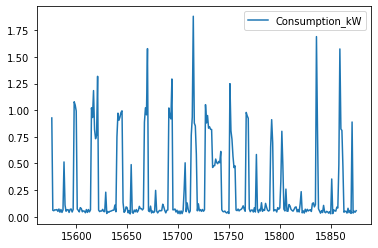

In [4]:
#Visualize examplary user
df[df.User == "User3"][:300].plot()

In [5]:
#Display basic statistics for each User
#Exclude User9, User 19

df_check = df
for counter in range(1,30):
    print("-----------------------------------------", counter)
    dfNew = df_check[df_check.User == "User{}".format(counter)]
    display(dfNew.tail())
    display(dfNew.describe().T)

    dfNew= dfNew.replace(0.0, np.nan)
    null_percentage= dfNew.isnull().mean()*100
    print('Null values in each column in percentages:', null_percentage)

----------------------------------------- 1


,Date,User,Consumption_kW
8755,2013-06-30 20:00:00,User1,0.213
8756,2013-06-30 21:00:00,User1,0.190
8757,2013-06-30 22:00:00,User1,0.274
8758,2013-06-30 23:00:00,User1,0.166
8759,2013-06-30 00:00:00,User1,0.631


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.293394,0.298903,0.0,0.104,0.176,0.36,2.113


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.045662
dtype: float64
----------------------------------------- 2


,Date,User,Consumption_kW
15571,2013-06-30 20:00:00,User2,0.317
15572,2013-06-30 21:00:00,User2,0.224
15573,2013-06-30 22:00:00,User2,0.303
15574,2013-06-30 23:00:00,User2,0.158
15575,2013-06-30 00:00:00,User2,0.121


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,6816.0,0.315668,0.328199,0.0,0.143,0.221,0.3,2.71


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.044014
dtype: float64
----------------------------------------- 3


,Date,User,Consumption_kW
24331,2013-06-30 20:00:00,User3,0.050
24332,2013-06-30 21:00:00,User3,0.112
24333,2013-06-30 22:00:00,User3,0.056
24334,2013-06-30 23:00:00,User3,0.065
24335,2013-06-30 00:00:00,User3,0.052


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.110617,0.183069,0.0,0.053,0.063,0.081,1.968


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 4


,Date,User,Consumption_kW
33091,2013-06-30 20:00:00,User4,0.273
33092,2013-06-30 21:00:00,User4,0.253
33093,2013-06-30 22:00:00,User4,0.134
33094,2013-06-30 23:00:00,User4,0.140
33095,2013-06-30 00:00:00,User4,0.107


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.199986,0.241797,0.0,0.101,0.134,0.219,2.937


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.034247
dtype: float64
----------------------------------------- 5


,Date,User,Consumption_kW
41851,2013-06-30 20:00:00,User5,1.993
41852,2013-06-30 21:00:00,User5,0.814
41853,2013-06-30 22:00:00,User5,0.390
41854,2013-06-30 23:00:00,User5,1.068
41855,2013-06-30 00:00:00,User5,0.999


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.228826,0.2879,0.0,0.091,0.131,0.238,3.135


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 6


,Date,User,Consumption_kW
50611,2013-06-30 20:00:00,User6,0.910
50612,2013-06-30 21:00:00,User6,1.011
50613,2013-06-30 22:00:00,User6,1.063
50614,2013-06-30 23:00:00,User6,1.044
50615,2013-06-30 00:00:00,User6,0.910


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.484991,0.321911,0.0,0.262,0.377,0.6,2.94


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.022831
dtype: float64
----------------------------------------- 7


,Date,User,Consumption_kW
59371,2013-06-30 20:00:00,User7,0.103
59372,2013-06-30 21:00:00,User7,0.076
59373,2013-06-30 22:00:00,User7,0.084
59374,2013-06-30 23:00:00,User7,0.075
59375,2013-06-30 00:00:00,User7,0.118


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.188046,0.197814,0.0,0.091,0.131,0.2,2.146


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 8


,Date,User,Consumption_kW
68131,2013-06-30 20:00:00,User8,0.104
68132,2013-06-30 21:00:00,User8,0.086
68133,2013-06-30 22:00:00,User8,0.203
68134,2013-06-30 23:00:00,User8,0.114
68135,2013-06-30 00:00:00,User8,0.099


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.486504,0.535202,0.0,0.138,0.283,0.656,4.941


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 9


,Date,User,Consumption_kW
76891,2013-06-30 20:00:00,User9,0.053
76892,2013-06-30 21:00:00,User9,0.048
76893,2013-06-30 22:00:00,User9,0.072
76894,2013-06-30 23:00:00,User9,0.074
76895,2013-06-30 00:00:00,User9,0.067


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.123594,0.270106,0.0,0.011,0.041,0.1,2.424


Null values in each column in percentages: Date               0.000000
User               0.000000
Consumption_kW    16.883562
dtype: float64
----------------------------------------- 10


,Date,User,Consumption_kW
85651,2013-06-30 20:00:00,User10,0.873
85652,2013-06-30 21:00:00,User10,0.113
85653,2013-06-30 22:00:00,User10,0.092
85654,2013-06-30 23:00:00,User10,0.041
85655,2013-06-30 00:00:00,User10,0.040


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.16245,0.231283,0.0,0.044,0.094,0.17,2.448


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 11


,Date,User,Consumption_kW
94411,2013-06-30 20:00:00,User11,0.687
94412,2013-06-30 21:00:00,User11,0.675
94413,2013-06-30 22:00:00,User11,0.747
94414,2013-06-30 23:00:00,User11,0.291
94415,2013-06-30 00:00:00,User11,0.325


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.379058,0.319332,0.0,0.146,0.2455,0.52725,3.038


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 12


,Date,User,Consumption_kW
103171,2013-06-30 20:00:00,User12,1.347
103172,2013-06-30 21:00:00,User12,1.615
103173,2013-06-30 22:00:00,User12,1.636
103174,2013-06-30 23:00:00,User12,1.460
103175,2013-06-30 00:00:00,User12,0.827


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.342725,0.198586,0.0,0.198,0.317,0.449,2.568


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 13


,Date,User,Consumption_kW
111931,2013-06-30 20:00:00,User13,0.282
111932,2013-06-30 21:00:00,User13,1.193
111933,2013-06-30 22:00:00,User13,0.132
111934,2013-06-30 23:00:00,User13,0.047
111935,2013-06-30 00:00:00,User13,0.072


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.246561,0.383437,0.0,0.047,0.1065,0.246,3.266


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.034247
dtype: float64
----------------------------------------- 14


,Date,User,Consumption_kW
120691,2013-06-30 20:00:00,User14,0.940
120692,2013-06-30 21:00:00,User14,0.290
120693,2013-06-30 22:00:00,User14,0.265
120694,2013-06-30 23:00:00,User14,0.982
120695,2013-06-30 00:00:00,User14,0.191


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.261756,0.28584,0.0,0.118,0.16,0.239,2.409


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 15


,Date,User,Consumption_kW
129451,2013-06-30 20:00:00,User15,0.095
129452,2013-06-30 21:00:00,User15,0.115
129453,2013-06-30 22:00:00,User15,0.080
129454,2013-06-30 23:00:00,User15,0.080
129455,2013-06-30 00:00:00,User15,0.038


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.116916,0.114102,0.0,0.059,0.086,0.13,1.646


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.022831
dtype: float64
----------------------------------------- 16


,Date,User,Consumption_kW
138211,2013-06-30 20:00:00,User16,0.507
138212,2013-06-30 21:00:00,User16,0.219
138213,2013-06-30 22:00:00,User16,0.105
138214,2013-06-30 23:00:00,User16,0.119
138215,2013-06-30 00:00:00,User16,0.104


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.400516,0.424828,0.0,0.127,0.225,0.49725,3.77


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.022831
dtype: float64
----------------------------------------- 17


,Date,User,Consumption_kW
146971,2013-06-30 20:00:00,User17,0.510
146972,2013-06-30 21:00:00,User17,0.487
146973,2013-06-30 22:00:00,User17,0.197
146974,2013-06-30 23:00:00,User17,0.171
146975,2013-06-30 00:00:00,User17,0.264


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.51979,0.517272,0.0,0.186,0.321,0.614,3.992


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 18


,Date,User,Consumption_kW
155731,2013-06-30 20:00:00,User18,2.083
155732,2013-06-30 21:00:00,User18,1.005
155733,2013-06-30 22:00:00,User18,1.011
155734,2013-06-30 23:00:00,User18,1.232
155735,2013-06-30 00:00:00,User18,0.349


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.227256,0.243202,0.0,0.08,0.119,0.275,2.421


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.034247
dtype: float64
----------------------------------------- 19


,Date,User,Consumption_kW
164491,2013-06-30 20:00:00,User19,0.081
164492,2013-06-30 21:00:00,User19,0.050
164493,2013-06-30 22:00:00,User19,0.088
164494,2013-06-30 23:00:00,User19,0.144
164495,2013-06-30 00:00:00,User19,0.069


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.152477,0.151186,0.0,0.081,0.113,0.169,2.106


Null values in each column in percentages: Date              0.00000
User              0.00000
Consumption_kW    0.10274
dtype: float64
----------------------------------------- 20


,Date,User,Consumption_kW
173251,2013-06-30 20:00:00,User20,0.563
173252,2013-06-30 21:00:00,User20,0.700
173253,2013-06-30 22:00:00,User20,0.650
173254,2013-06-30 23:00:00,User20,0.563
173255,2013-06-30 00:00:00,User20,0.688


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.433911,0.62217,0.0,0.1,0.2,0.419,4.4


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.045662
dtype: float64
----------------------------------------- 21


,Date,User,Consumption_kW
182011,2013-06-30 20:00:00,User21,0.508
182012,2013-06-30 21:00:00,User21,0.485
182013,2013-06-30 22:00:00,User21,0.541
182014,2013-06-30 23:00:00,User21,0.955
182015,2013-06-30 00:00:00,User21,1.238


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.534656,0.462797,0.0,0.205,0.3695,0.706,4.223


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 22


,Date,User,Consumption_kW
190771,2013-06-30 20:00:00,User22,0.112
190772,2013-06-30 21:00:00,User22,0.070
190773,2013-06-30 22:00:00,User22,0.155
190774,2013-06-30 23:00:00,User22,0.075
190775,2013-06-30 00:00:00,User22,0.070


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.234843,0.398101,0.0,0.071,0.096,0.178,3.886


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 23


,Date,User,Consumption_kW
199531,2013-06-30 20:00:00,User23,0.218
199532,2013-06-30 21:00:00,User23,0.295
199533,2013-06-30 22:00:00,User23,0.492
199534,2013-06-30 23:00:00,User23,0.476
199535,2013-06-30 00:00:00,User23,0.476


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.221655,0.229022,0.0,0.078,0.158,0.27,2.176


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.079909
dtype: float64
----------------------------------------- 24


,Date,User,Consumption_kW
208291,2013-06-30 20:00:00,User24,0.104
208292,2013-06-30 21:00:00,User24,0.651
208293,2013-06-30 22:00:00,User24,0.215
208294,2013-06-30 23:00:00,User24,0.104
208295,2013-06-30 00:00:00,User24,0.096


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.299439,0.289558,0.0,0.131,0.169,0.35525,2.67


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 25


,Date,User,Consumption_kW
217051,2013-06-30 20:00:00,User25,1.875
217052,2013-06-30 21:00:00,User25,1.788
217053,2013-06-30 22:00:00,User25,1.163
217054,2013-06-30 23:00:00,User25,0.275
217055,2013-06-30 00:00:00,User25,0.338


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.386588,0.629112,0.0,0.075,0.125,0.325,4.288


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 26


,Date,User,Consumption_kW
225811,2013-06-30 20:00:00,User26,1.225
225812,2013-06-30 21:00:00,User26,0.750
225813,2013-06-30 22:00:00,User26,0.788
225814,2013-06-30 23:00:00,User26,0.763
225815,2013-06-30 00:00:00,User26,2.300


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.488016,0.470957,0.0,0.175,0.281,0.713,3.738


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 27


,Date,User,Consumption_kW
234571,2013-06-30 20:00:00,User27,0.830
234572,2013-06-30 21:00:00,User27,1.658
234573,2013-06-30 22:00:00,User27,0.821
234574,2013-06-30 23:00:00,User27,0.804
234575,2013-06-30 00:00:00,User27,0.122


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.324918,0.320438,0.0,0.104,0.207,0.44825,2.606


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.011416
dtype: float64
----------------------------------------- 28


,Date,User,Consumption_kW
243331,2013-06-30 20:00:00,User28,0.225
243332,2013-06-30 21:00:00,User28,0.931
243333,2013-06-30 22:00:00,User28,0.119
243334,2013-06-30 23:00:00,User28,0.100
243335,2013-06-30 00:00:00,User28,0.100


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.213539,0.209653,0.0,0.119,0.156,0.231,2.95


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.079909
dtype: float64
----------------------------------------- 29


,Date,User,Consumption_kW
252091,2013-06-30 20:00:00,User29,0.389
252092,2013-06-30 21:00:00,User29,0.749
252093,2013-06-30 22:00:00,User29,0.391
252094,2013-06-30 23:00:00,User29,0.093
252095,2013-06-30 00:00:00,User29,0.064


,count,mean,std,min,25%,50%,75%,max
Consumption_kW,8760.0,0.270533,0.292523,0.0,0.077,0.168,0.335,2.162


Null values in each column in percentages: Date              0.000000
User              0.000000
Consumption_kW    0.034247
dtype: float64


In [6]:
# Pivot the dataframe
pivot_df = df.pivot(index='Date', columns='User', values='Consumption_kW').reset_index()

# Rename the columns
pivot_df.columns.name = None

load_final = pivot_df

# Print the resulting dataframe
load_final.head()

,Date,User1,User10,User11,User12,User13,User14,User15,User16,User17,...,User33,User34,User35,User36,User4,User5,User6,User7,User8,User9
0,2012-07-01 00:00:00,0.068,0.703,0.353,0.210,0.138,0.208,0.065,0.340,0.129,...,0.284,0.244,0.397,0.102,0.090,0.098,0.636,0.106,0.156,0.012
1,2012-07-01 01:00:00,0.786,0.036,0.547,0.197,0.343,0.176,0.067,0.508,0.121,...,0.661,0.331,0.276,0.077,0.084,0.098,0.253,0.098,0.151,0.022
2,2012-07-01 02:00:00,0.544,0.045,0.519,0.163,0.339,0.164,0.057,0.542,0.141,...,0.276,0.169,0.305,0.025,0.084,0.075,0.220,0.089,0.152,0.023
3,2012-07-01 03:00:00,0.612,0.031,0.324,0.173,0.337,0.178,0.063,0.590,0.165,...,0.293,0.169,0.304,0.036,0.091,0.072,0.241,0.103,0.148,0.012
4,2012-07-01 04:00:00,0.665,0.018,0.343,0.156,0.363,0.193,0.065,0.551,0.122,...,0.276,0.113,0.261,0.054,0.091,0.092,0.199,0.090,0.146,0.038


In [7]:
#Save as CSV file
load_final.to_csv('../2012-2013 Load_preprocessed.csv', index=False)